# P-values for simple binned cut-and-count experiments

Here, we perform a simple cut and count experiment, drawing data from a 2D Gaussian. Binning the distributions we calculate the expectation value per pin using the pdf of the distribution (i.e. oversampling infinitely) and use Poisson statistics to obtain the significance.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm
from sklearn.ensemble import HistGradientBoostingClassifier

In [7]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

First we define some helper functions including one generating the data, one calculating p-values from significances and one (with its own helper function) calculating the significances themselves using the Asimov estimate.

In [8]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    #a = 1-stats.nbinom.cdf(N_BT-1, N_data, k)
    #b = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    #inds = np.where(N_data>N_BT, 0, 1)
    #return inds*a +(1-inds)*b

    #if N_data < N_BT:
    #    return 1-stats.nbinom.cdf(N_BT-1, N_data, k)
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_poisson(N_data, N_BT):
    return 1-stats.poisson.cdf(N_data-1, N_BT)

def p_value_binomial(N_data, N_BT, N_total):
    return 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)

def sig(N, b, err):
    """
    Complicated significance formula calculation where N=N_obs, b = N_exp and err=delta_sys
    """
    if err==0:
        s=N-b
        x=N*np.log(1+s/b)-s
        x[x<0]=0
        return np.sqrt(2*(x))
    s = N - b
    ln1 = N * (b+err**2) / (b**2+N*err**2)
    ln1 = 2 * N * np.log(ln1)

    ln2 = 1 + err**2 * s / b / (b+err**2)
    ln2 = 2 * b**2 / err**2 * np.log(ln2)
    x = ln1 - ln2
    x[x<0]=0
    return np.sqrt(x)

def significance_formula(N_data, N_BT):
    return sig(N_data, N_BT, 0)

def significance_naive(N_data, N_BT):
    return (N_data-N_BT)/np.sqrt(N_BT)

In [9]:
def do_test(N_tests, bins, N, bins_edge = None):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    p_poisson = np.zeros((bins,bins, N_tests))
    p_binomial = np.zeros((bins,bins, N_tests))
    for k in tqdm.tqdm(range(N_tests)):
        data = rv.rvs(size=N, random_state=k)
        hist = np.histogramdd(data, bins=edges)[0]
        p_poisson[:,:, k] = p_value_poisson(hist, exp)
        p_binomial[:,:,k] = p_value_binomial(hist, exp, N)
    return p_poisson, p_binomial       

def make_plot(N_samples_after, N_samples, N_after, N, colors, labels, trials=None, title=None, remove_0=True):
    plt.figure()
    plt.title(title)
    plt.ylabel("p-value")
    plt.xlabel("Actual rate")

    p = []
    trials = []
    counts = []
    for i in range(len(N[0])):
        if remove_0:
            inds = np.nonzero(N_samples_after[:,i])[0]
            inds2 = np.nonzero(N_after[inds,i])[0]
            p.append(np.sort(p_value_poissonpoisson_2tailed(N_after[inds,i][inds2], N_samples_after[inds,i][inds2]/N_samples[inds,i][inds2]*N[inds,i][inds2])))
        else: 
            p.append(np.sort(p_value_poissonpoisson_2tailed(N_after[:,i], N_samples_after[:,i]/N_samples[:,i]*N[:,i])))
        trials.append(len(p[i]))
        counts.append(np.arange(1, trials[i]+1))
        plt.scatter(counts[i]/trials[i], p[i], marker=".", color=colors[i])

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    a = min([xmin, ymin])
    b = max([xmax, ymax])
    plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
    plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    for i in range(len(N[0])):
        plt.scatter(counts[i]/trials[i], p[i], marker=".", color=colors[i], label=labels[i])
    plt.legend()

    plt.figure()
    plt.title(title)
    plt.ylabel("p-value")
    plt.xlabel("Actual rate")
    plt.xscale("log")
    plt.yscale("log")
    for i in range(len(N[0])):
        plt.scatter(counts[i]/trials[i], p[i], marker=".", color=colors[i])
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    a = min([xmin, ymin])
    b = max([xmax, ymax])
    plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
    plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    for i in range(len(N[0])):
        plt.scatter(counts[i]/trials[i], p[i], marker=".", color=colors[i], label=labels[i])
    plt.legend()


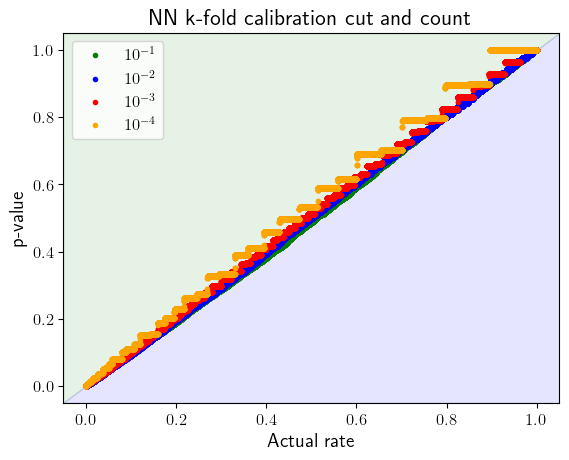

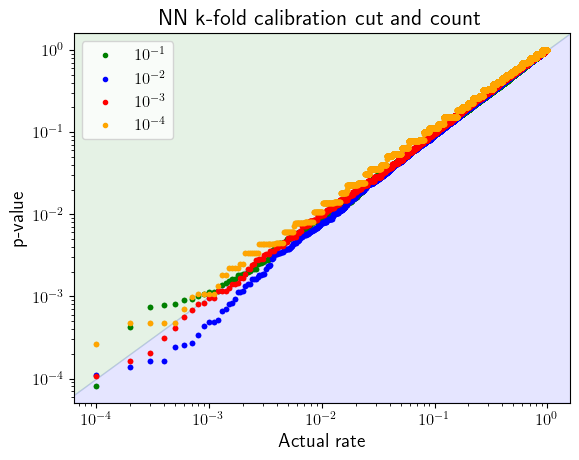

In [10]:
folder = "/hpcwork/zu992399/look_elsewhere/NN_kfold_calibration/"
N_samples_after = np.concatenate((np.load(folder+"N_samples_after_small.npy"),np.load(folder+"N_samples_after.npy")),axis=1)
N_samples = np.concatenate((np.load(folder+"N_samples_small.npy"),np.load(folder+"N_samples.npy")), axis=1)
N_after = np.concatenate((np.load(folder+"N_after_small.npy"),np.load(folder+"N_after.npy")), axis=1)
N = np.concatenate((np.load(folder+"N_small.npy"),np.load(folder+"N.npy")), axis=1)

make_plot(N_samples_after, N_samples, N_after, N, ("green", "blue", "red", "orange"), (r"$10^{-1}$",r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"), title="NN k-fold calibration cut and count")

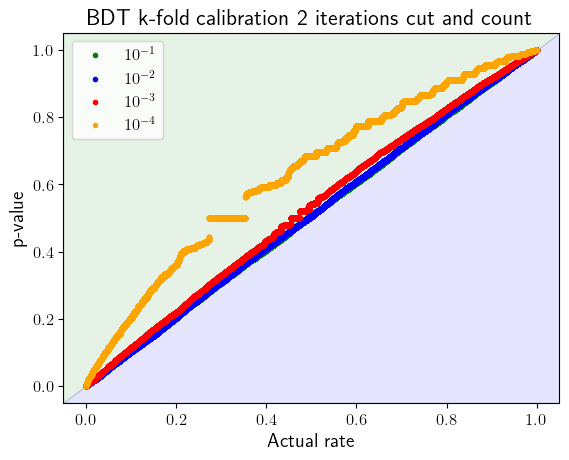

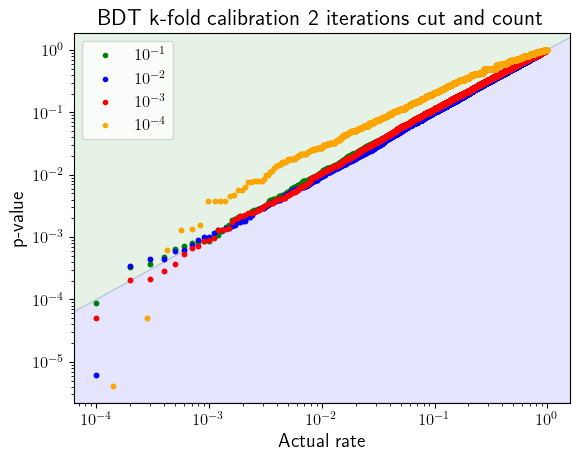

In [ ]:
folder = "/hpcwork/zu992399/look_elsewhere/BDT_calibration_kfold_niter1/"
N_samples_after = np.load(folder+"N_samples_after.npy")
N_samples = np.load(folder+"N_samples.npy")
N_after = np.load(folder+"N_after.npy")
N = np.load(folder+"N.npy")

make_plot(N_samples_after, N_samples, N_after, N, ("green", "blue", "red", "orange"), (r"$10^{-1}$",r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"), title="BDT k-fold calibration 2 iterations cut and count")

(1000, 4)
[0. 0. 0. 0.]


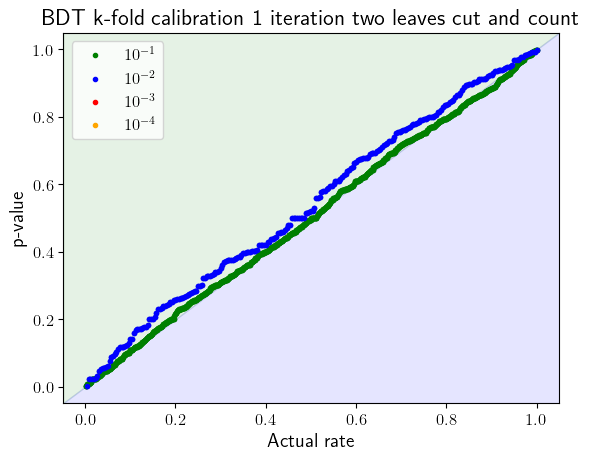

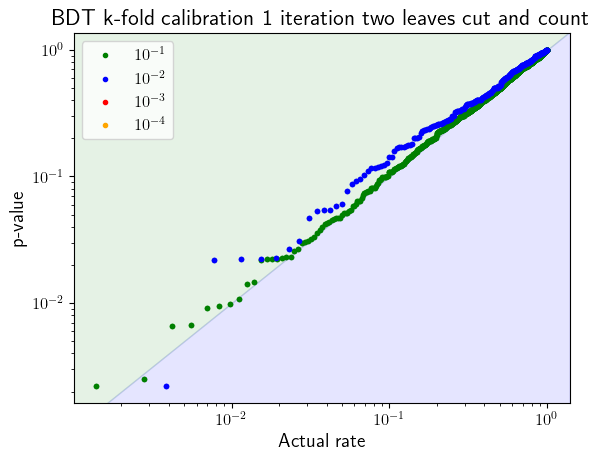

In [ ]:
folder = "/hpcwork/zu992399/look_elsewhere/BDT_calibration_kfold_niter1_leaves2/"
N_samples_after = np.load(folder+"N_samples_after.npy")
N_samples = np.load(folder+"N_samples.npy")
N_after = np.load(folder+"N_after.npy")
N = np.load(folder+"N.npy")
print(N.shape)
print(N_after[100])
make_plot(N_samples_after, N_samples, N_after, N, ("green", "blue", "red", "orange"), (r"$10^{-1}$",r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"), title="BDT k-fold calibration 1 iteration two leaves cut and count")

(10000, 4)
[22243.  1993.   139.     0.]
(10000, 4)
[2.4972e+04 2.5250e+03 2.2000e+02 2.3000e+01]
(10000, 4)
[2.4795e+04 2.5020e+03 2.2900e+02 8.0000e+00]
(10000, 4)
[2.4351e+04 2.4570e+03 1.3000e+02 2.2000e+01]
(10000, 4)
[2.4723e+04 2.6620e+03 1.6700e+02 5.0000e+00]
(10000, 4)
[2.478e+04 2.008e+03 1.550e+02 9.000e+00]
(10000, 4)
[13170.  1375.   143.    14.]


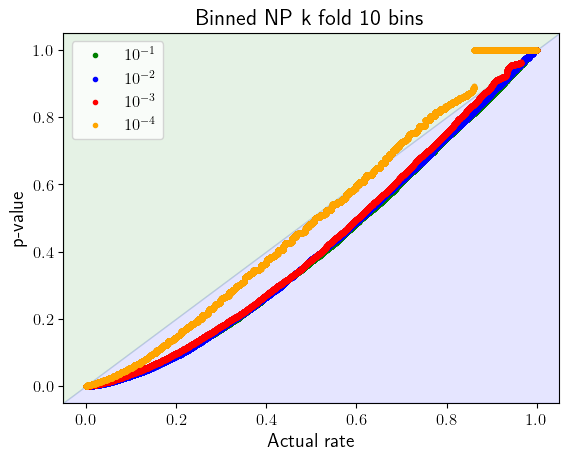

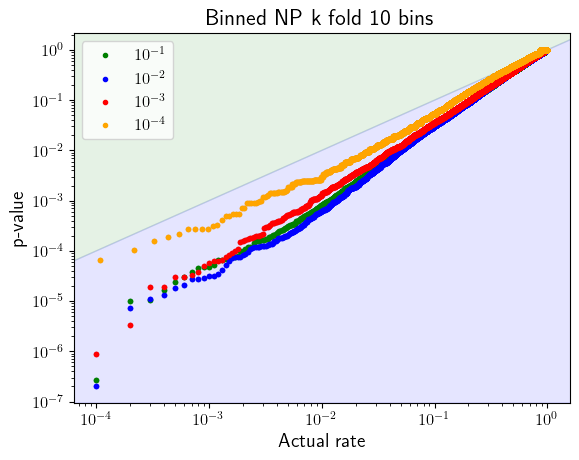

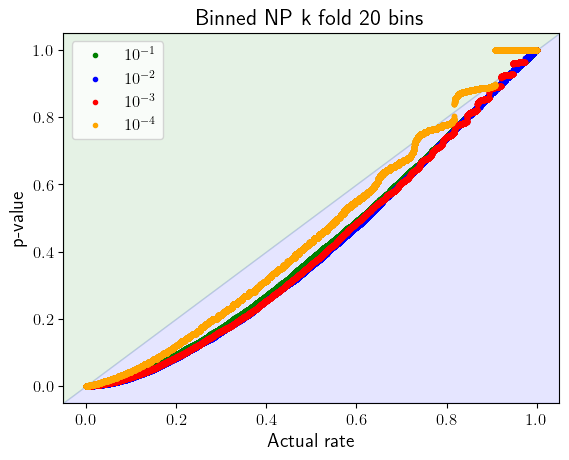

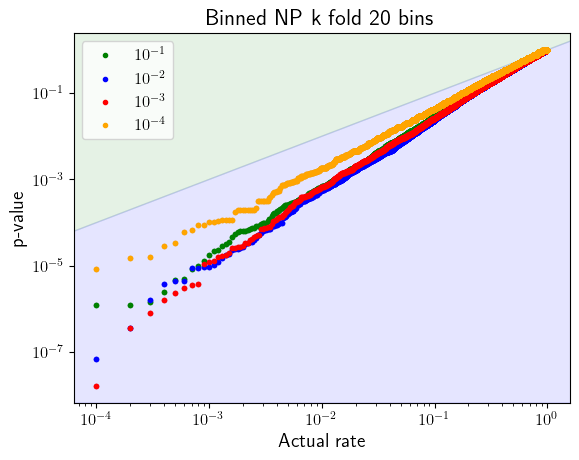

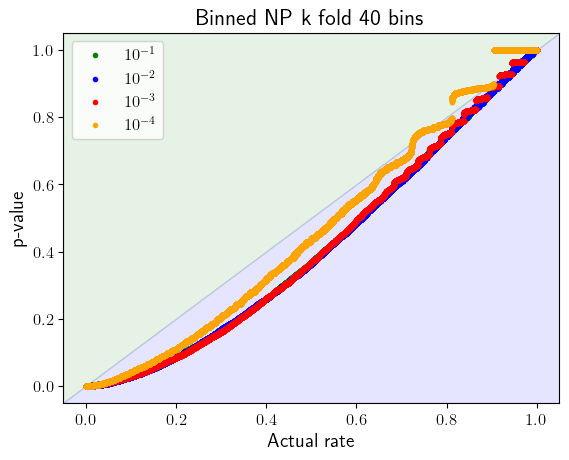

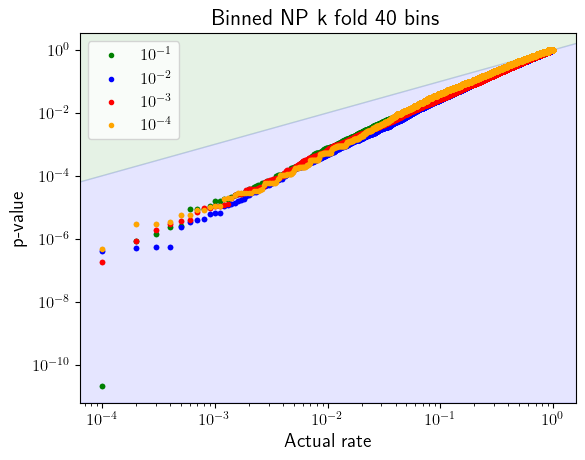

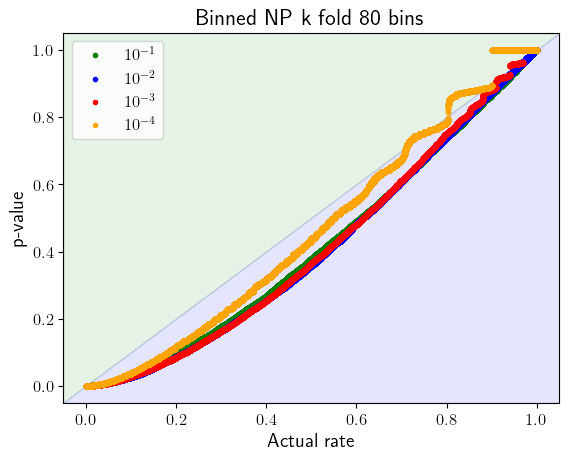

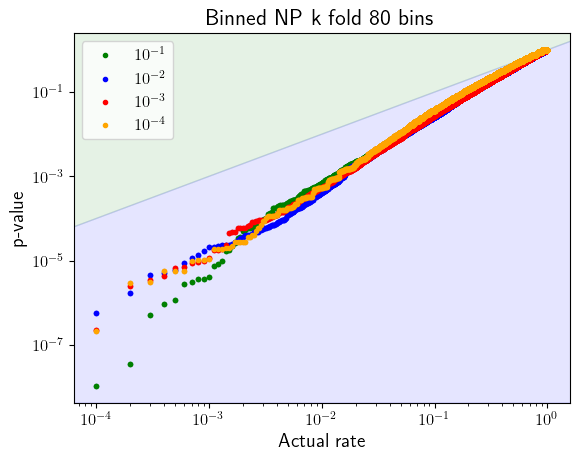

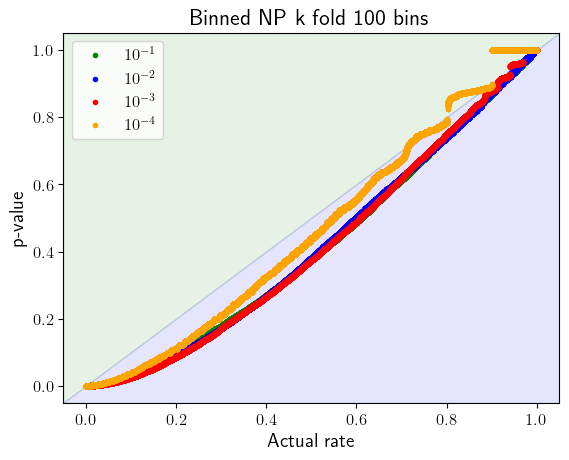

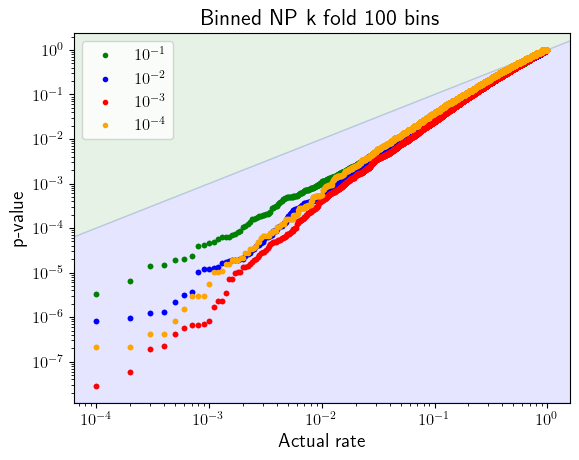

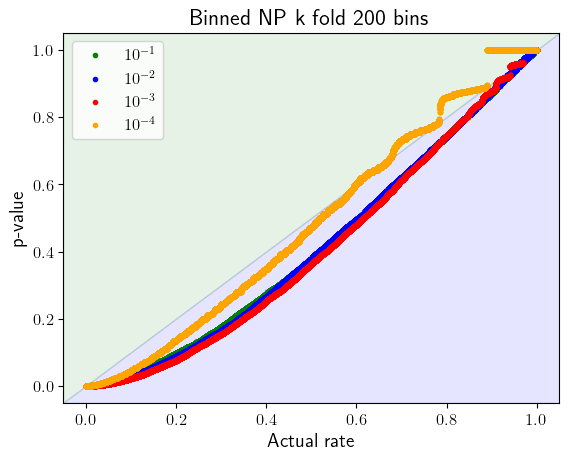

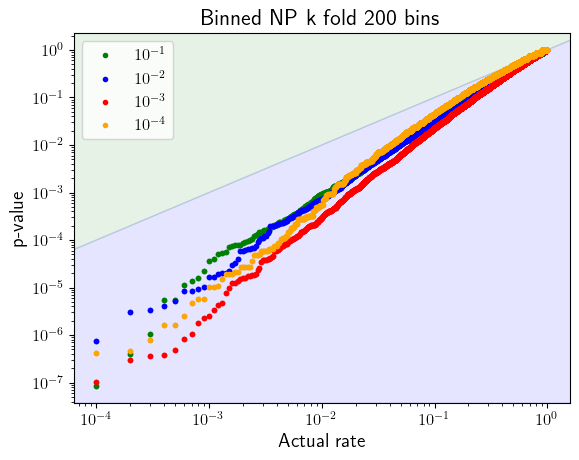

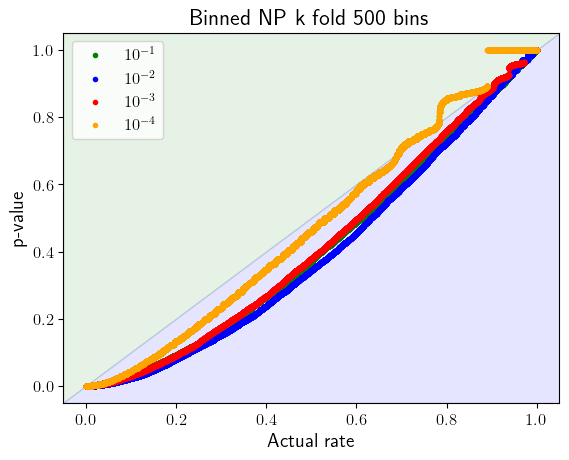

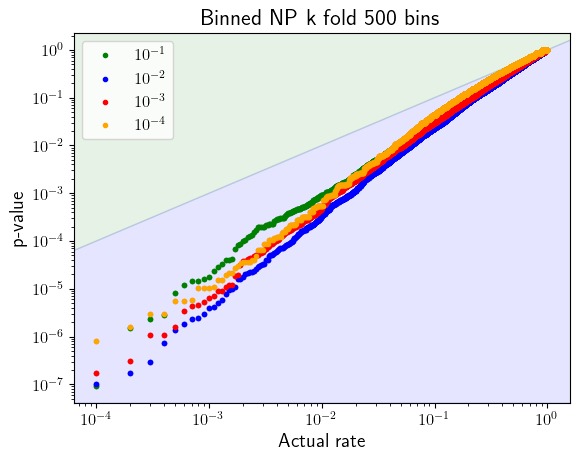

In [11]:
bins=[10, 20, 40, 80, 100, 200, 500]
for b in bins:
    folder = "/hpcwork/rwth0934/look_elsewhere/binned_NP/kfold_bins"+str(b)+"/"
    N_samples_after = np.load(folder+"N_samples_after.npy")
    N_samples = np.load(folder+"N_samples.npy")
    N_after = np.load(folder+"N_after.npy")
    N = np.load(folder+"N.npy")
    print(N.shape)
    print(N_after[100])
    make_plot(N_samples_after, N_samples, N_after, N, ("green", "blue", "red", "orange"), (r"$10^{-1}$",r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"), title="Binned NP k fold "+ str(b)+" bins")